In [1]:

#import library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import scipy.io as scio 
import scipy.io as sio
from tf_utils import random_mini_batches_single, convert_to_one_hot
from tensorflow.python.framework import ops
#from tfdeterminism import patch
#patch()

In [2]:
def create_placeholders(n_x, n_y):
    
    isTraining = tf.placeholder_with_default(True, shape=())
    x = tf.placeholder(tf.float32, [None, n_x], name = "x")
    y = tf.placeholder(tf.float32, [None, n_y], name = "Y")

    return x, y, isTraining

def initialize_parameters():

    
    tf.set_random_seed(1)
     
    x_w1 = tf.get_variable("x_w1", [1,1,200,128], initializer = tf.keras.initializers.glorot_normal(seed = 1))
    x_b1 = tf.get_variable("x_b1", [128], initializer = tf.zeros_initializer())
    
    x_w2 = tf.get_variable("x_w2", [1,1,128,16], initializer = tf.keras.initializers.glorot_normal(seed = 1))
    x_b2 = tf.get_variable("x_b2", [16], initializer = tf.zeros_initializer())
    
    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_w2": x_w2,
                  "x_b2": x_b2}

    return parameters

In [3]:
def mynetwork(x, parameters, isTraining, momentums = 0.9):
    
    x = tf.reshape(x, [-1, 1, 1, 200], name = "x")
    
    with tf.name_scope("x_layer_1"):
         
         x_z1 = tf.nn.conv2d(x, parameters['x_w1'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_b1'] 
         x_z1_bn = tf.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)   
         x_a1 = tf.nn.relu(x_z1_bn)
         
    with tf.name_scope("x_layer_3"):
        
         x_z2 = tf.nn.conv2d(x_a1, parameters['x_w2'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_b2'] 
         
         x_z2_shape = x_z2.get_shape().as_list()
         x_z2_2d = tf.reshape(x_z2, [-1, x_z2_shape[1] * x_z2_shape[2] * x_z2_shape[3]])
                    
         
    l2_loss =   tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_w2'])
               
    return x_z2_2d, l2_loss

def mynetwork_optimaization(y_es, y_re, l2_loss, reg, learning_rate, global_step):

    with tf.name_scope("cost"):
        
         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_es, labels = y_re)) + reg * l2_loss
               
    with tf.name_scope("optimization"):
         update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost, global_step=global_step)
         optimizer = tf.group([optimizer, update_ops])
         
    return cost, optimizer

In [4]:
def train_mynetwork(x_train_set, y_train_set, x_test_set, y_test_set, learning_rate_base = 0.001, beta_reg = 0.001, num_epochs = 200, minibatch_size = 32, print_cost = True):
    tf.compat.v1.disable_eager_execution()
    ops.reset_default_graph()                       
    tf.set_random_seed(1)                          
    seed = 1                                    
    (m, n_x) = x_train_set.shape                        
    (m, n_y) = y_train_set.shape                            

    costs = []                                   
    costs_dev = []
    train_acc = []
    val_acc = []
    correct_prediction = 0
    
    # Create Placeholders of shape (n_x, n_y)
    x, y, isTraining = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    with tf.name_scope("network"):

         x_out, l2_loss= mynetwork(x, parameters, isTraining)
         
    global_step = tf.Variable(0, trainable = False)
    learning_rate = tf.train.exponential_decay(learning_rate_base, global_step, 50 * m/minibatch_size, 0.5, staircase = True)
    
    with tf.name_scope("optimization"):
         # network optimization
         cost, optimizer = mynetwork_optimaization(x_out, y, l2_loss, beta_reg, learning_rate, global_step)

    with tf.name_scope("metrics"):
         # Calculate the correct predictions
         joint_layerT = tf.transpose(x_out)
         yT = tf.transpose(y)
         correct_prediction = tf.equal(tf.argmax(joint_layerT), tf.argmax(yT))
         accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs + 1):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            epoch_acc = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches_single(x_train_set, y_train_set, minibatch_size, seed)
            for minibatch in minibatches:

                # Select a minibatch
                (batch_x, batch_y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost, minibatch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x: batch_x, y: batch_y, isTraining: True})
           
                epoch_cost += minibatch_cost / (num_minibatches+ 1)
                epoch_acc += minibatch_acc / (num_minibatches + 1)
 
            features, epoch_cost_dev, epoch_acc_dev = sess.run([x_out, cost, accuracy], feed_dict={x: x_test_set, y: y_test_set, isTraining: False})

            # Print the cost every epoch
            if print_cost == True and (epoch) % 50 == 0:
                print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost, epoch_cost_dev, epoch_acc, epoch_acc_dev))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                train_acc.append(epoch_acc)
                costs_dev.append(epoch_cost_dev)
                val_acc.append(epoch_acc_dev)
        
        # plot the cost      
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(costs_dev))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        # plot the accuracy 
        plt.plot(np.squeeze(train_acc))
        plt.plot(np.squeeze(val_acc))
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
         
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
       
        return parameters, val_acc, features

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



/var/folders/z_/krw1gf615x7gd0lvqxvzk7ch0000gn/T/ipykernel_3449/3616401784.py:8: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_z1_bn = tf.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
2023-02-03 01:45:46.380521: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-03 01:45:46.381039: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-03 01:45:46.638015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-03 01:45:48.344208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


epoch 0: Train_loss: 2.090973, Val_loss: 2.143686, Train_acc: 0.289773, Val_acc: 0.277944
epoch 50: Train_loss: 0.474593, Val_loss: 2.480561, Train_acc: 0.836648, Val_acc: 0.411126
epoch 100: Train_loss: 0.314718, Val_loss: 1.827336, Train_acc: 0.906250, Val_acc: 0.536553
epoch 150: Train_loss: 0.239128, Val_loss: 1.694385, Train_acc: 0.928977, Val_acc: 0.571399
epoch 200: Train_loss: 0.200194, Val_loss: 1.014584, Train_acc: 0.943182, Val_acc: 0.690725


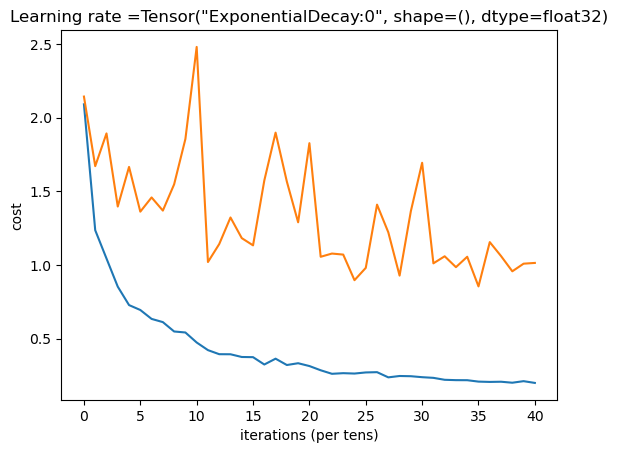

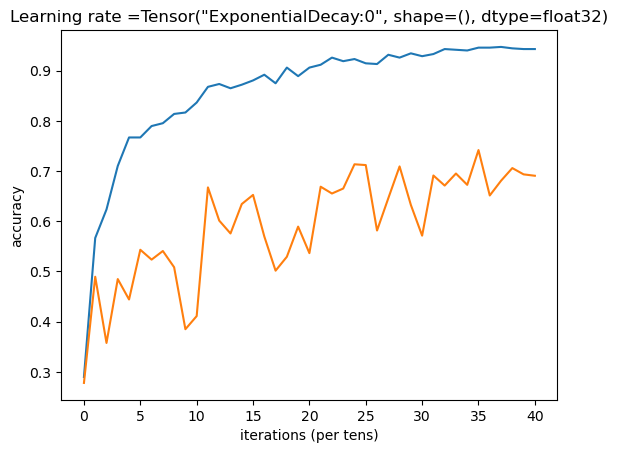

Parameters have been trained!


2023-02-03 01:46:41.690007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [5]:
Train_X = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/Train_X.mat')
TrLabel = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/TrLabel.mat')

Test_X = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/Test_X.mat')
TeLabel = scio.loadmat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/HSI_GCN/TeLabel.mat')

Train_X = Train_X['Train_X']
TrLabel = TrLabel['TrLabel']
Test_X = Test_X['Test_X']
TeLabel = TeLabel['TeLabel']

TrLabel = convert_to_one_hot(TrLabel-1, 16)
TeLabel = convert_to_one_hot(TeLabel-1, 16)

TrLabel = TrLabel.T
TeLabel = TeLabel.T

parameters, val_acc, features = train_mynetwork(Train_X, TrLabel, Test_X, TeLabel)
sio.savemat('/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Remote_sensing/seminar/hong/IEEE_TGRS_GCN-master/Indian pines datasets/features-1DCNN.mat', {'features': features})